# Assignment 

1. Use pytorch to model class face recognition using the master_dataset.npz

In [91]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose


In [92]:
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

In [93]:
import numpy as np

data = np.load('master_dataset.npz', allow_pickle=True)

In [94]:
data_img = data['images']
data_label = data['labels']
data_labelName = data['labelnames']

In [97]:
classes = {
    0: "afiq",
    1: "azureen",
    2: "gavin",
    3: "goke",
    4: "inamul",
    5: "jincheng",
    6: "mahmuda",
    7: "numan",
    8: "saseendran",
}

In [98]:
import cv2 as cv 

desiredShape = (200, 200, 3)

N = len(data_img)
shape = (N, desiredShape[0], desiredShape[1], desiredShape[2])

y = np.empty(shape, dtype='uint8')

for i in range(N):
    y[i] = cv.resize(data_img[i], [200,200], interpolation=cv.INTER_NEAREST)

data_img.dtype, y.dtype, y.shape

data_img = y

In [99]:
data_img = data_img / 255.0
data_images = torch.Tensor(data_img)

In [100]:
all_data = []
for i in range(len(data_images)):
   all_data.append([data_images[i], data_label[i]])

In [101]:
train_shape = int(0.8 * len(data_images))
test_shape = len(data_images) - train_shape


In [102]:
training_dataset, testing_dataset = torch.utils.data.random_split(all_data, [train_shape, test_shape])

## Visualize dataset

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
5


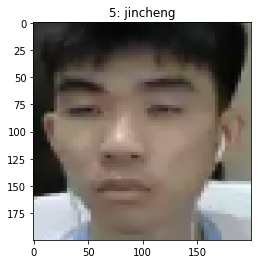

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
0


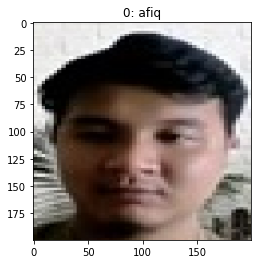

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
3


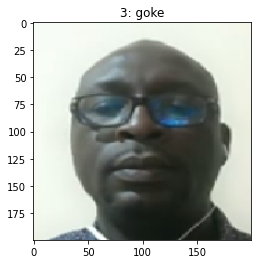

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
0


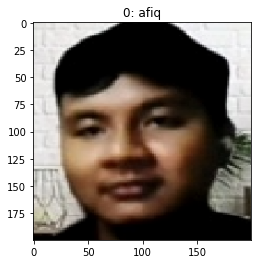

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
7


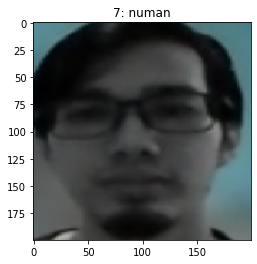

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
7


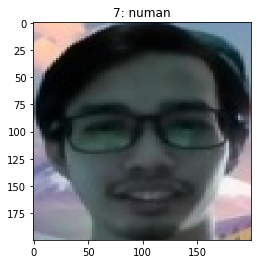

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
2


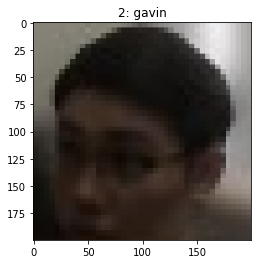

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
7


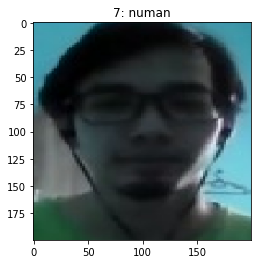

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
6


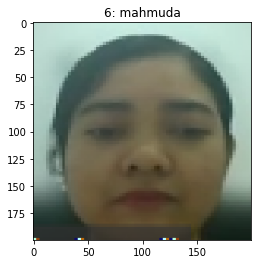

In [106]:
for i in range (1,10):

    x, y = training_dataset[i]
    print(x.shape)
    print(x.squeeze().shape)
    print(y)

    img = x.squeeze()
    plt.imshow(img, cmap="gray")
    plt.title(f"{y}: {classes[y]}")
    plt.show()

## Dataloader

In [107]:
batch_size = 60

# Create data loaders.
training_dataloader = DataLoader(training_dataset, batch_size=batch_size)
testing_dataloader = DataLoader(testing_dataset, batch_size=batch_size)

for x, y in testing_dataloader:
    print("Shape of X [N, C, H, W]: ", x.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([60, 200, 200, 3])
Shape of y:  torch.Size([60]) torch.int32


## Create Model

In [108]:
import torch

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

input_features = 3*200*200
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 9)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=120000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=9, bias=True)
  )
)


## Model Parameter

In [109]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## Train

In [110]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

## Testing

In [111]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Train and Testing

In [112]:
# epoch = point where the time starts, and is platform dependent

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_dataloader, model, loss_fn, optimizer)
    test(testing_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


RuntimeError: expected scalar type Long but found Int

# Save model

In [113]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


# Load model

In [114]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

# Prediction

In [140]:
model.eval()
x, y = testing_dataset[0][0], testing_dataset[8][1]
x = x.view(1, -1)
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0).item()], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "afiq", Actual: "afiq"


In [120]:
pred[0]

tensor([ 0.0520, -0.0295, -0.0453,  0.0339,  0.0490, -0.0549, -0.0075,  0.0311,
        -0.0303])

In [141]:
model.eval()
x, y = testing_dataset[2][0], testing_dataset[9][1]
x = x.view(1, -1)
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0).item()], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "inamul", Actual: "inamul"
